# ch05 Using a neural network to fit your data

## 5.1 Artificial neurons

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn

In [6]:
input_t = torch.arange(-3, 3.1, 0.1)
print('input: ', input)

input:  <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7f9f770908>>


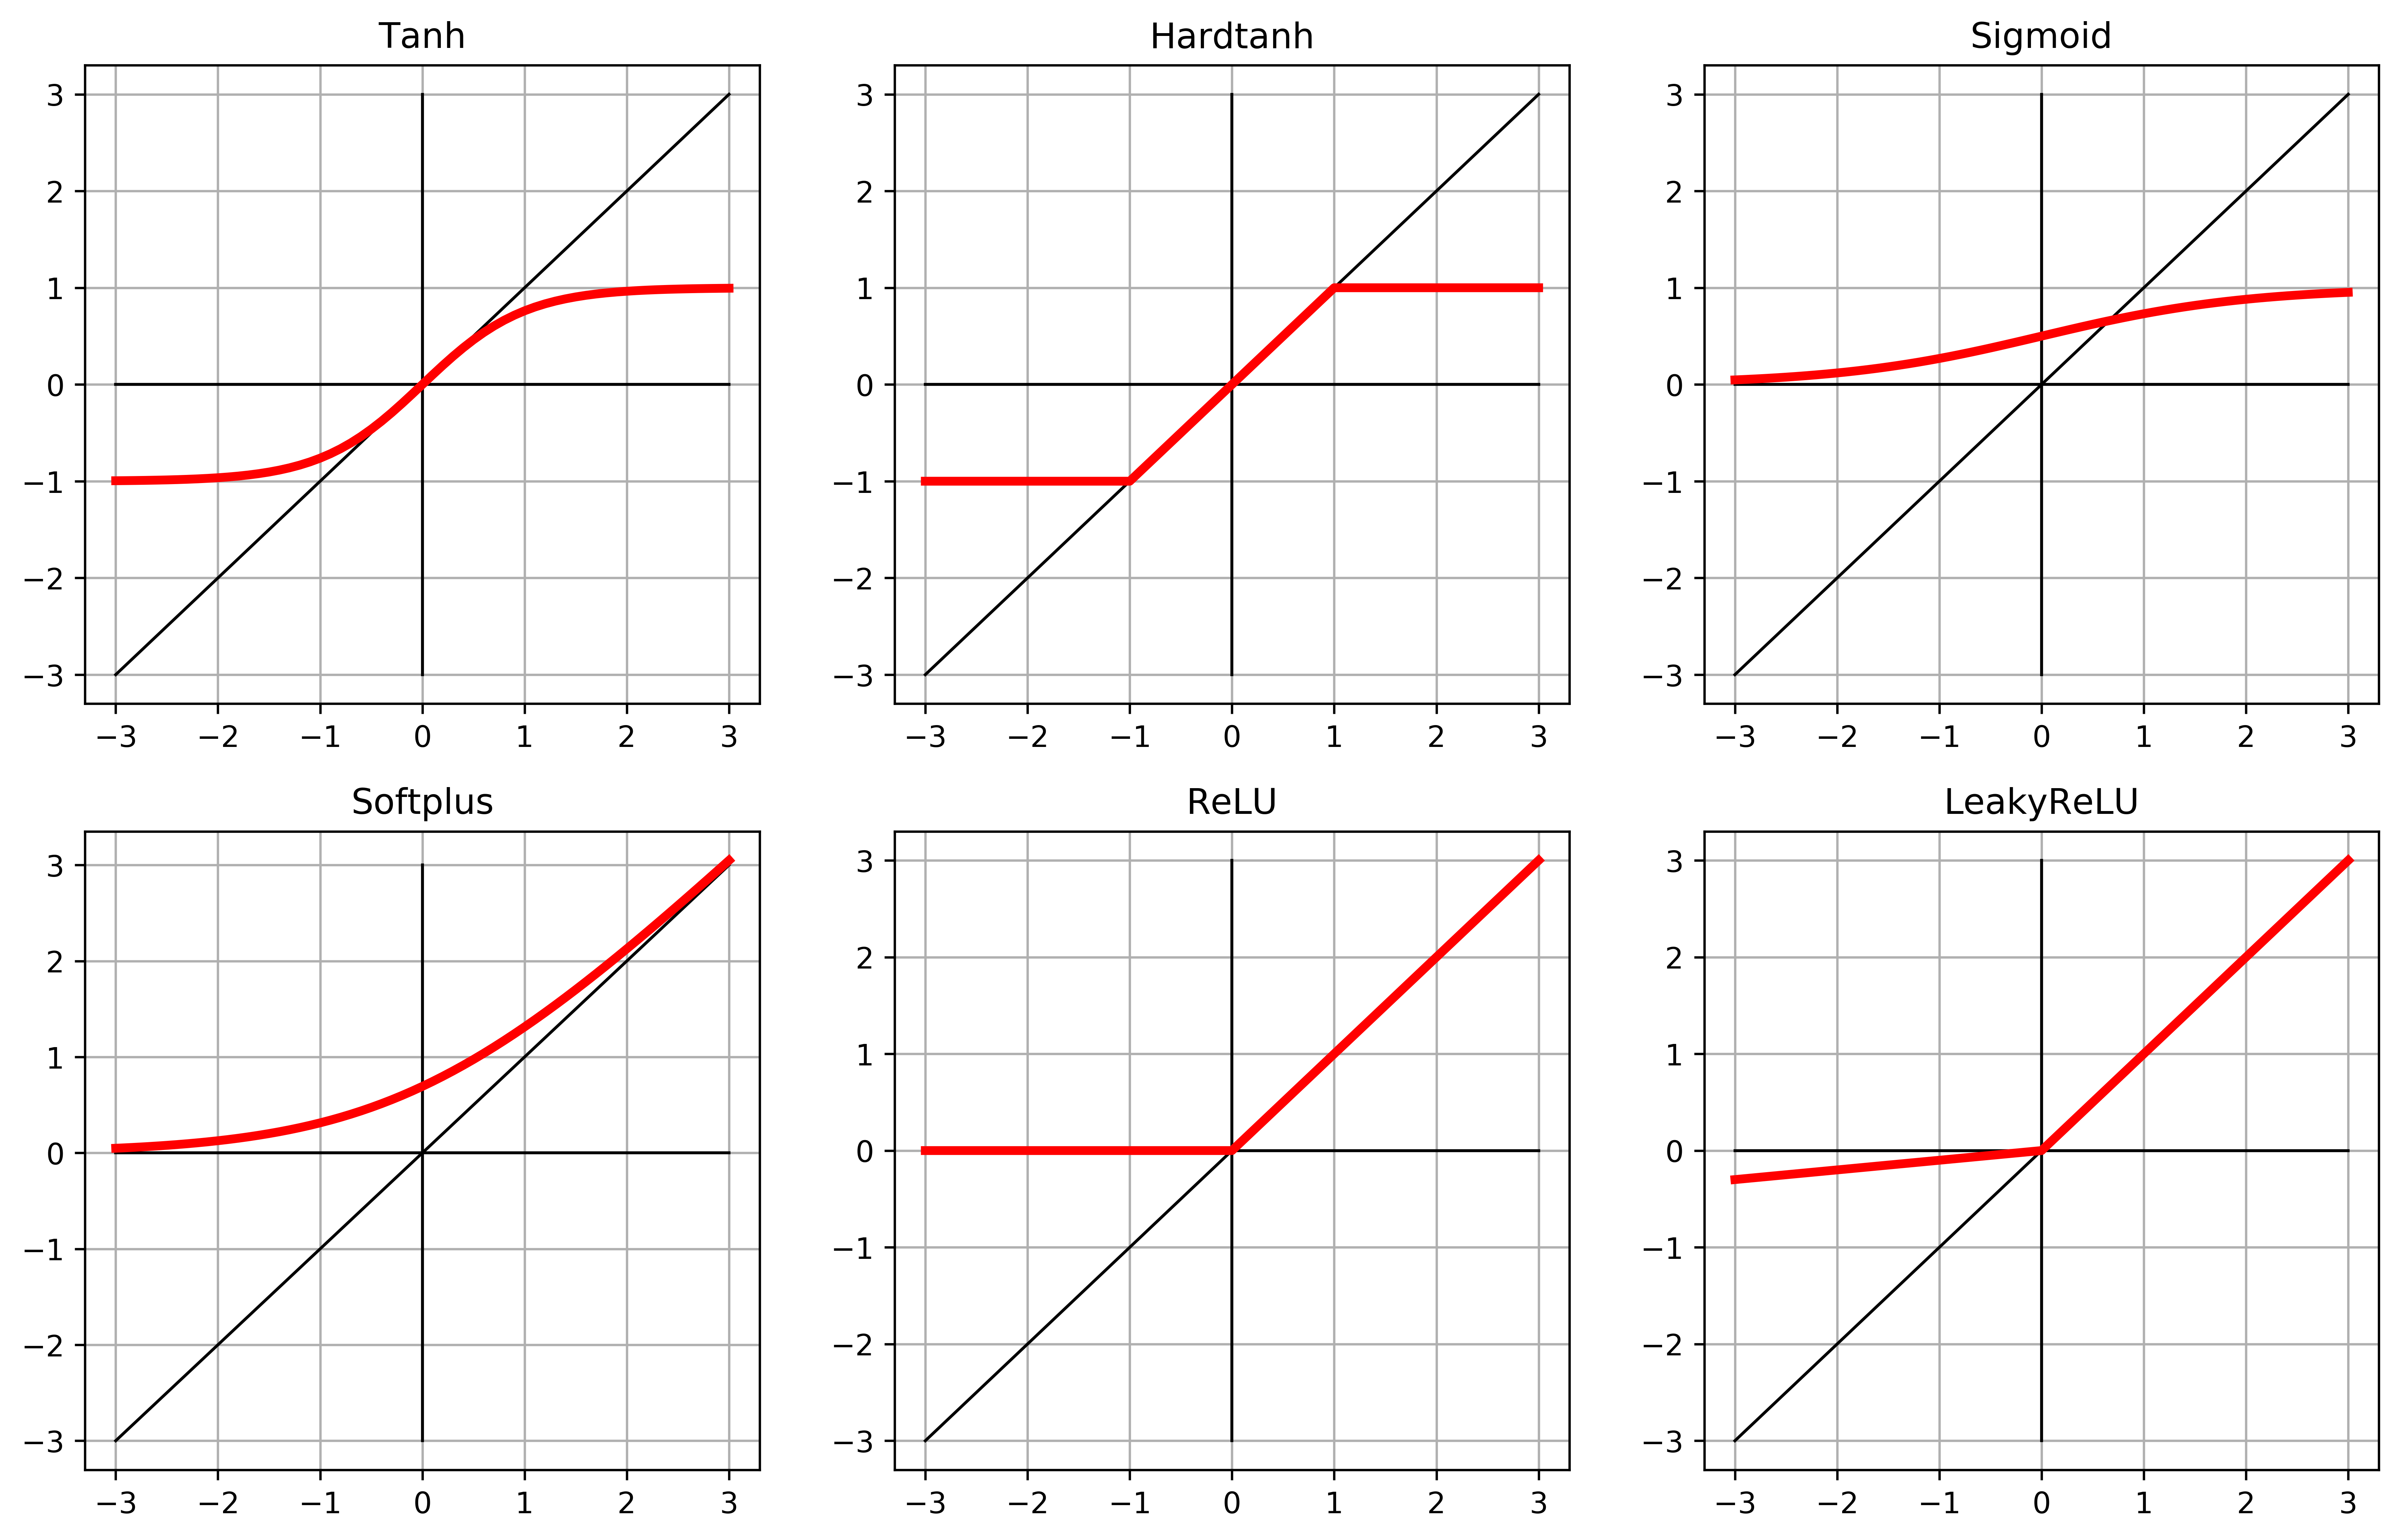

In [8]:
### 5.1.1 All you need is activation
# ReLU (Rectified Linear Unit) deserves special note, as it is currently considered
# to be one of the best-performing general activation functions, 

# Draw Activate functions.
activation_list = [
    nn.Tanh(),
    nn.Hardtanh(),
    nn.Sigmoid(),
    
    nn.Softplus(),
    nn.ReLU(),
    nn.LeakyReLU(negative_slope=0.1)
]

fig = plt.figure(figsize=(14, 28), dpi=600)

for i, activate_fun in enumerate(activation_list):
    # add_subplot(nrows, ncols, index, **kwargs)
    subplt = fig.add_subplot(len(activation_list), 3, i+1)
    subplt.set_title(type(activate_fun).__name__)
    
    output_t = activate_fun(input_t)
    
    plt.grid() # grid
    plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=1) # 45deg line 
    plt.plot([-3,3], [0,0], 'k', linewidth=1) # y axis
    plt.plot([0,0], [-3,3], 'k', linewidth=1) # x axis
    plt.plot(input_t.numpy(), output_t.numpy(), 'r', linewidth=3) # Activate function.

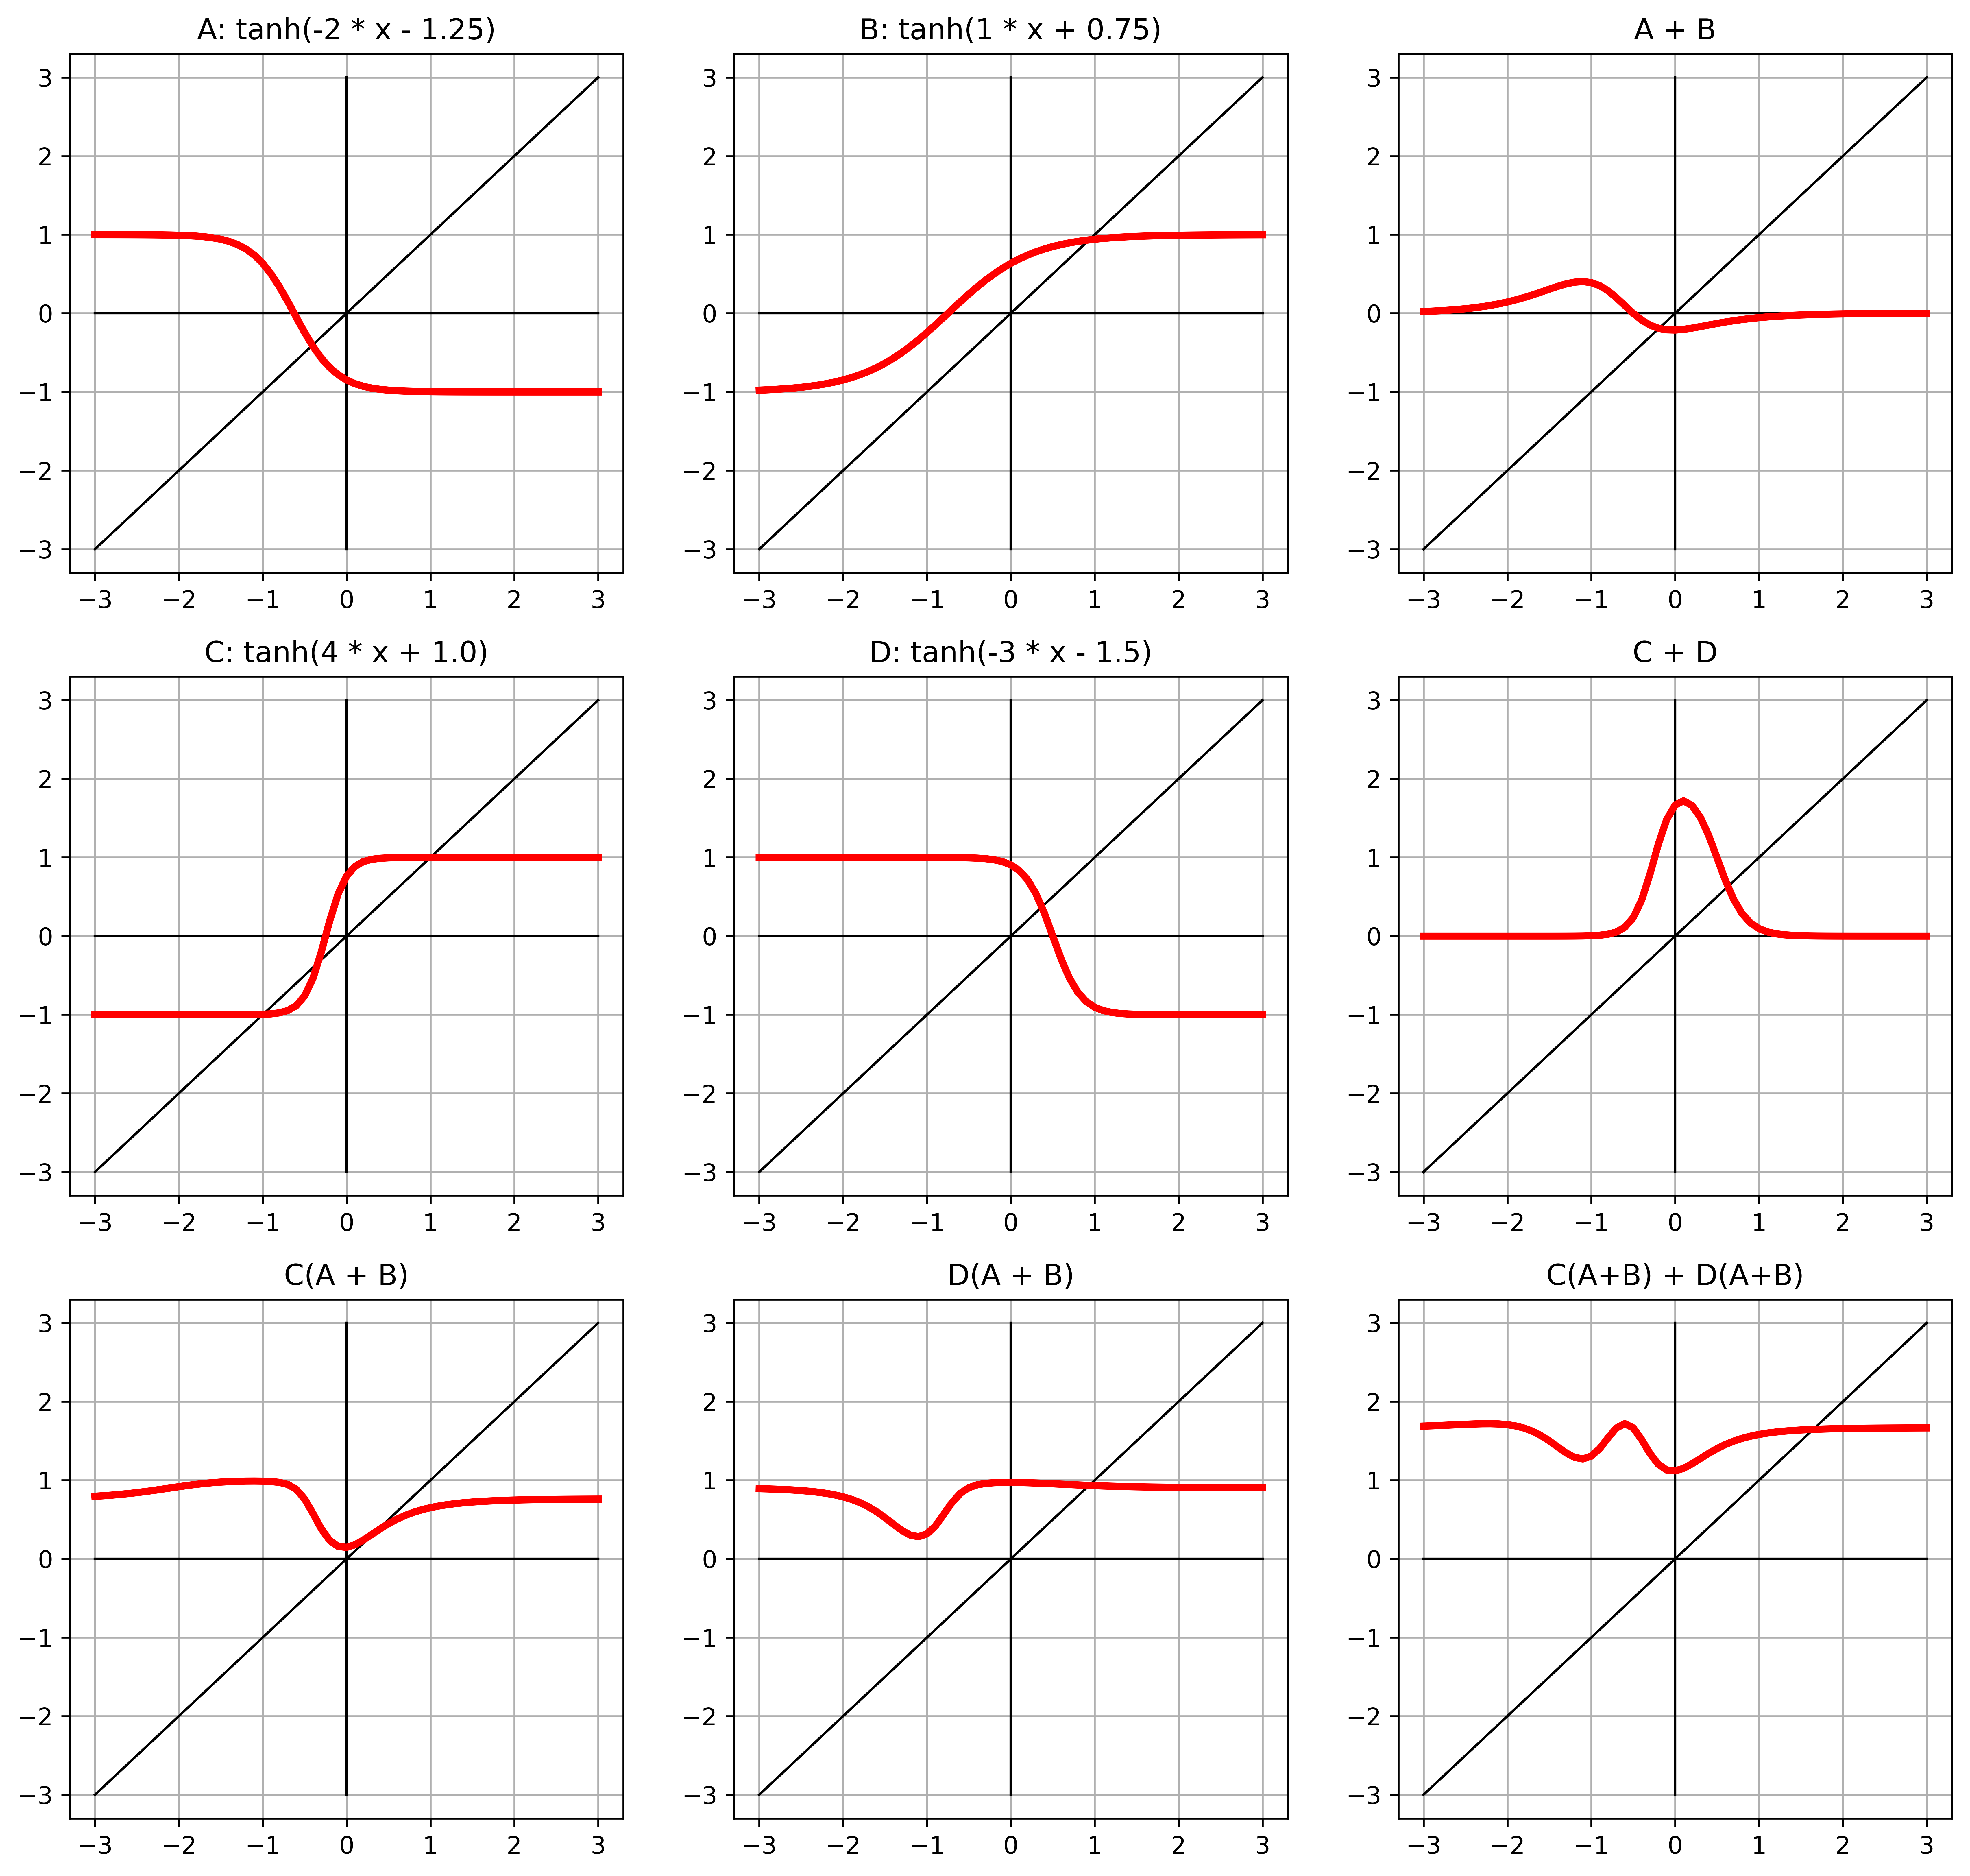

In [9]:
### 5.1.2 What learning means for a neural network
a = lambda x: nn.Tanh()(-2 * x - 1.25)
b = lambda x: nn.Tanh()( 1 * x + 0.75)
c = lambda x: nn.Tanh()( 4 * x + 1.)
d = lambda x: nn.Tanh()(-3 * x + 1.5)

wb_list = [
    ('A: tanh(-2 * x - 1.25)', a(input_t)),
    ('B: tanh(1 * x + 0.75)', b(input_t)),
    ('A + B', a(input_t) + b(input_t)),

    ('C: tanh(4 * x + 1.0)', c(input_t)),
    ('D: tanh(-3 * x - 1.5)', d(input_t)),
    ('C + D', c(input_t) + d(input_t)),

    ('C(A + B)', c(a(input_t) + b(input_t))),
    ('D(A + B)', d(a(input_t) + b(input_t))),
     
    ('C(A+B) + D(A+B)', c(a(input_t) + b(input_t)) + d(a(input_t) + b(input_t))),
]

fig = plt.figure(figsize=(14, 42), dpi=600)

for i, (title_str, output_t) in enumerate(wb_list):
    subplot = fig.add_subplot(len(wb_list), 3, i+1)
    subplot.set_title(title_str)
    
    plt.grid()
    plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=1) # 45deg line
    plt.plot([-3,3], [0,0], 'k', linewidth=1) # y axis
    plt.plot([0,0], [-3,3], 'k', linewidth=1) # x axis
    plt.plot(input_t.numpy(), output_t.numpy(), 'r', linewidth=3) # Function


## 5.2 The PyTorch nn module

In [18]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

# input
t_u_val = t_u[-2:]
t_un_val= t_u_val.unsqueeze(1)*0.1
print('t_un_val.shape: ', t_un_val.shape)

# torch.nn
import torch.nn as nn
# torch.nn.Linear(in_features: int, out_features: int, bias: bool = True)
# out = w*x + b
linear_model = nn.Linear(1, 1)
print('out: ', linear_model(t_un_val))

print('linear_model.weight: ', linear_model.weight)
print('linear_model: ', linear_model.bias)


t_un_val.shape:  torch.Size([2, 1])
out:  tensor([[3.7232],
        [4.3329]], grad_fn=<AddmmBackward>)
linear_model.weight:  Parameter containing:
tensor([[0.7621]], requires_grad=True)
linear_model:  Parameter containing:
tensor([-0.8800], requires_grad=True)


In [19]:
# Batch
x = torch.ones(1)
linear_model(x)

x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.1179],
        [-0.1179],
        [-0.1179],
        [-0.1179],
        [-0.1179],
        [-0.1179],
        [-0.1179],
        [-0.1179],
        [-0.1179],
        [-0.1179]], grad_fn=<AddmmBackward>)

In [20]:
# nn.Linear()'s Params.
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.7621]], requires_grad=True),
 Parameter containing:
 tensor([-0.8800], requires_grad=True)]

In [28]:
# Split train & val dataset
n_samples = t_u.shape[0]
n_val = int(0.2*n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val] # Before the last n_val samples.
val_indices = shuffled_indices[-n_val:] # The last n_val samples. 

# Get train & val set.
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

# Add dim 1
train_t_u = train_t_u.unsqueeze(1)
train_t_c = train_t_c.unsqueeze(1)
val_t_u = val_t_u.unsqueeze(1)
val_t_c = val_t_c.unsqueeze(1)

In [29]:
# Optimizer
import torch.optim as optim
optimizer = optim.Adam(
    linear_model.parameters(),
    lr = 1e-2
)

In [30]:
# Loss function
# def loss_fn(t_p, t_c):
#     squared_diffs = (t_p-t_c)**2
#     return squared_diffs.mean()

# Training loop.
def training_loop(n_epochs, optimizer, model, loss_fn, 
                  t_u_train, t_c_train, t_u_val, t_c_val):
    for epoch in range(1, n_epochs+1):
        # Forward
        t_p_train = model(t_u_train)
        # Loss
        loss_train = loss_fn(t_p_train, t_c_train)
        
        # val
        with torch.no_grad(): # No grad
            t_p_val = model(t_u_val)
            loss_val = loss_fn(t_p_val, t_c_val)
        
        # Backward
        optimizer.zero_grad() # Clear grad.
        loss_train.backward() 
        optimizer.step() # Update parameters.
        
        # Print
        if (epoch % 500 == 0):
            print('epoch: %d, train_loss: %f, val_loss: %f' %(epoch, loss_train, loss_val))
            print('params: ', list(model.parameters()))

In [31]:
# Invoke the training loop
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # use nn.MSELoss
    t_u_train = train_t_u,
    t_c_train = train_t_c,
    t_u_val = val_t_u,
    t_c_val = val_t_c
)

epoch: 500, train_loss: 34.078609, val_loss: 41.073357
params:  [Parameter containing:
tensor([[0.2135]], requires_grad=True), Parameter containing:
tensor([1.7803], requires_grad=True)]
epoch: 1000, train_loss: 21.401253, val_loss: 28.251362
params:  [Parameter containing:
tensor([[0.2867]], requires_grad=True), Parameter containing:
tensor([-2.4563], requires_grad=True)]
epoch: 1500, train_loss: 12.962114, val_loss: 19.193678
params:  [Parameter containing:
tensor([[0.3510]], requires_grad=True), Parameter containing:
tensor([-6.1764], requires_grad=True)]
epoch: 2000, train_loss: 7.739542, val_loss: 13.078093
params:  [Parameter containing:
tensor([[0.4060]], requires_grad=True), Parameter containing:
tensor([-9.3597], requires_grad=True)]
epoch: 2500, train_loss: 4.831660, val_loss: 9.187244
params:  [Parameter containing:
tensor([[0.4511]], requires_grad=True), Parameter containing:
tensor([-11.9713], requires_grad=True)]
epoch: 3000, train_loss: 3.441967, val_loss: 6.890250
param

In [32]:
# nn.Sequential()
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [34]:
# Print named parameters.
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [36]:
# Sequential also accepts an OrderedDict4 in
# which you can name each module passed to Sequential
from collections import OrderedDict
seq_model = nn.Sequential(
    OrderedDict([
        ('input_linear', nn.Linear(1, 8)),
        ('hidden_activation', nn.Tanh()),
        ('output_linear', nn.Linear(8, 1))
    ])
)
seq_model

Sequential(
  (input_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [37]:
# Print named parameters.
for name, param in seq_model.named_parameters():
    print(name, param.shape)

input_linear.weight torch.Size([8, 1])
input_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [38]:
# You can also get to a particular Parameter by accessing submodules as though they
# were attributes
seq_model.output_linear.bias

Parameter containing:
tensor([-0.3475], requires_grad=True)

In [39]:
# Invoke training  loop again.
train_t_un = train_t_u*0.1
val_t_un = val_t_u*0.1
# optimizer
optimizer = optim.SGD(
    seq_model.parameters(),
    lr = 1e-3
)

# 
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(), # use nn.MSELoss
    t_u_train = train_t_un,
    t_c_train = train_t_c,
    t_u_val = val_t_un,
    t_c_val = val_t_c
)

epoch: 500, train_loss: 16.562096, val_loss: 8.596213
params:  [Parameter containing:
tensor([[ 0.4451],
        [-0.2036],
        [ 0.1687],
        [ 0.6530],
        [-0.4553],
        [ 0.4601],
        [-0.3843],
        [ 0.7337]], requires_grad=True), Parameter containing:
tensor([-2.1612,  0.2470,  0.2700, -0.2688,  2.2315,  0.4259,  1.7361,  0.1337],
       requires_grad=True), Parameter containing:
tensor([[ 3.2888, -2.0563,  2.1711,  1.6730, -3.2885,  1.7642, -2.6593,  1.6150]],
       requires_grad=True), Parameter containing:
tensor([1.4164], requires_grad=True)]
epoch: 1000, train_loss: 4.065626, val_loss: 4.658351
params:  [Parameter containing:
tensor([[ 0.4945],
        [-0.3045],
        [ 0.2766],
        [ 0.2999],
        [-0.5033],
        [ 0.2720],
        [-0.4299],
        [ 0.6524]], requires_grad=True), Parameter containing:
tensor([-2.7568,  0.5827,  0.0376, -0.4439,  2.8218,  0.3274,  2.2517,  0.0953],
       requires_grad=True), Parameter containing:
ten

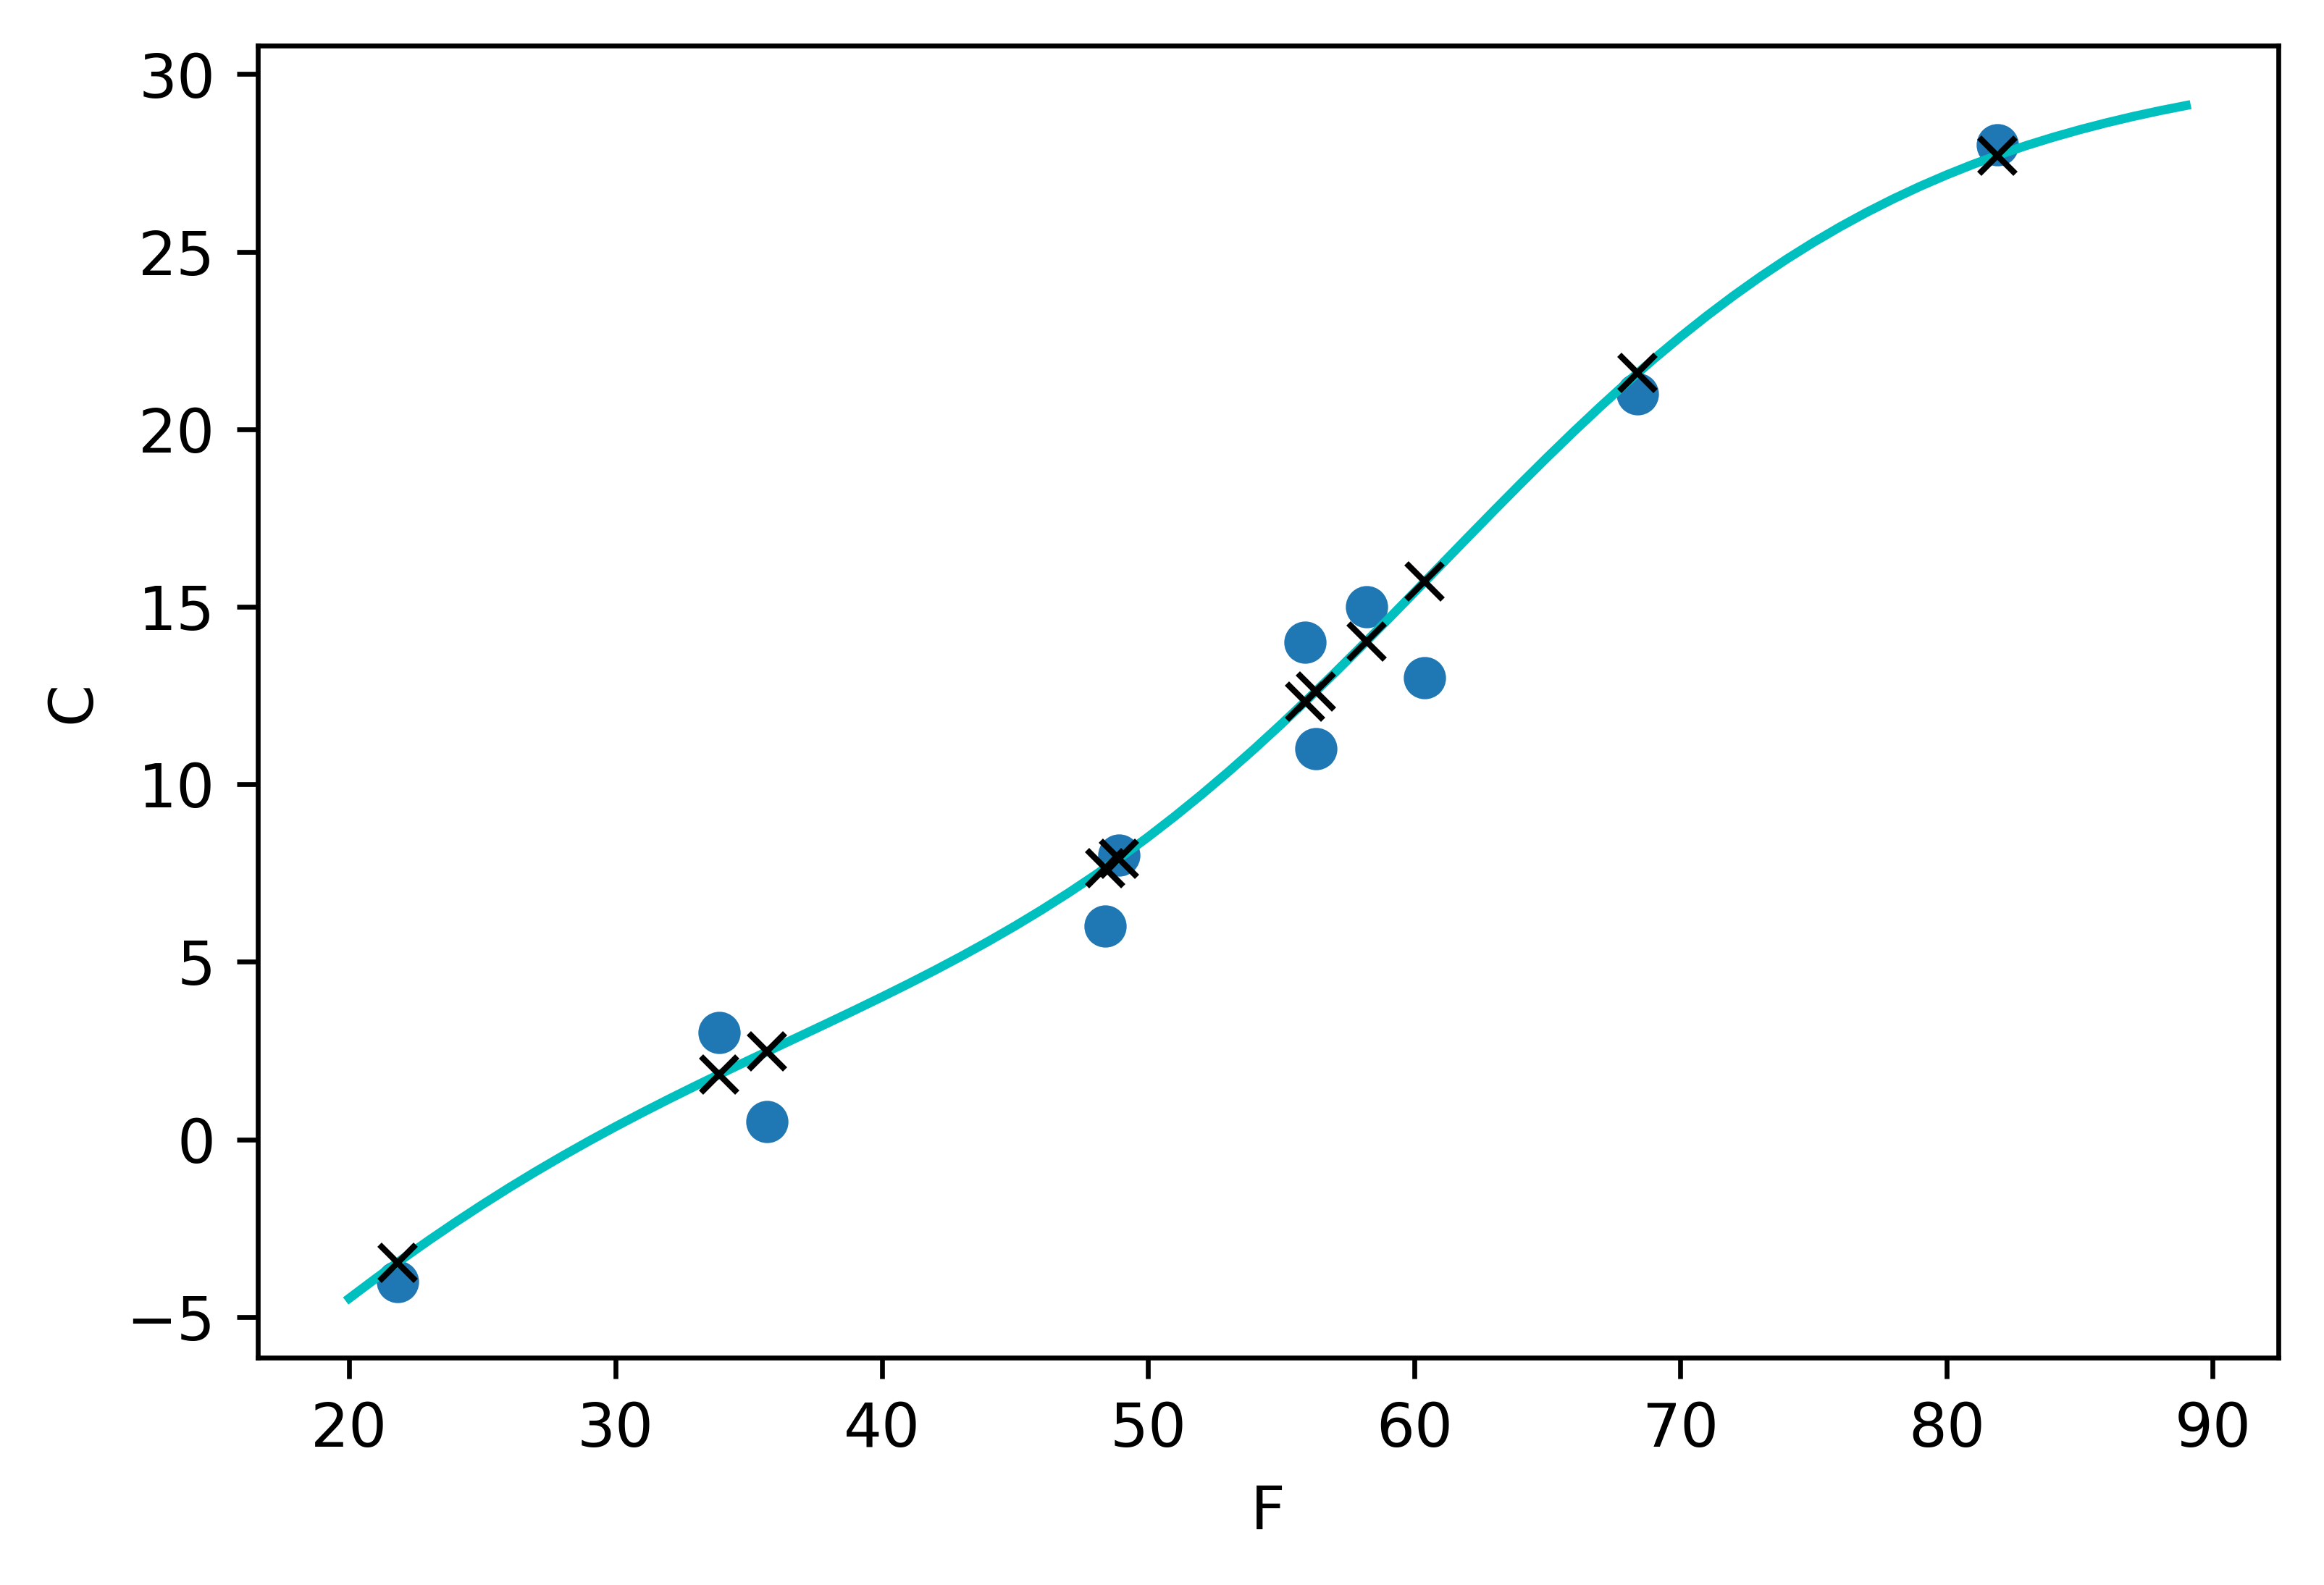

In [42]:
# Plot the model results.
# Anyone who does data science should be plotting data all the time.

%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(dpi=600)
plt.xlabel('F')
plt.ylabel('C')

# data
t_range = torch.arange(20., 90.).unsqueeze(1) # add dim 1
t_u = t_u.unsqueeze(1)

# plot
plt.plot(t_u.numpy(), t_c.numpy(), 'o') # raw data
# 'c-': color: cyan, '-' solid line style
plt.plot(t_range.numpy(), seq_model(t_range*0.1).detach().numpy(), 'c-') # t_range
# 'k': black, 'x': x marker
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx') # t_u

## 5.3 Subclassing nn.Module

In [ ]:
# We'll show you three ways to implement the same network structure

In [43]:
# 1. seq_model
seq_model = nn.Sequential(
    nn.Linear(1, 11),
    nn.Tanh(),
    nn.Linear(11, 1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=11, bias=True)
  (1): Tanh()
  (2): Linear(in_features=11, out_features=1, bias=True)
)

In [44]:
# 2. named seq_model
from collections import OrderedDict
namedseq_model = nn.Sequential(
    OrderedDict([
        ('input_linear', nn.Linear(1, 12)),
        ('hidden_activation', nn.Tanh()),
        ('output_linear', nn.Linear(12, 1))
    ])
)
namedseq_model

Sequential(
  (input_linear): Linear(in_features=1, out_features=12, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=12, out_features=1, bias=True)
)

In [47]:
# You can take full control of the processing of input
# data by subclassing nn.Module yourself
# 3. subclass nn.Module
class SubclassModule(nn.Module):
    def __init__(self):
        super().__init__() # base class init.
        # netword
        # registering submodules in the constructor so that you can access their parameters
        self.input_linear = nn.Linear(1, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)
        
    def forward(self, input):
        hidden_t = self.input_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.output_linear(activated_t)
        
        return output_t

# Instantial
subclass_model = SubclassModule()
subclass_model
        

SubclassModule(
  (input_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [49]:
# Compare params.
for type_str, model in [('seq', seq_model), ('namedseq', namedseq_model),
    ('subclass', subclass_model)]:
    print(type_str)
    for name_str, param in model.named_parameters():
        print("{:21} {:19} {}".format(name_str, str(param.shape), param.numel()))
    print()

seq
0.weight              torch.Size([11, 1]) 11
0.bias                torch.Size([11])    11
2.weight              torch.Size([1, 11]) 11
2.bias                torch.Size([1])     1

namedseq
input_linear.weight   torch.Size([12, 1]) 12
input_linear.bias     torch.Size([12])    12
output_linear.weight  torch.Size([1, 12]) 12
output_linear.bias    torch.Size([1])     1

subclass
input_linear.weight   torch.Size([13, 1]) 13
input_linear.bias     torch.Size([13])    13
output_linear.weight  torch.Size([1, 13]) 13
output_linear.bias    torch.Size([1])     1



In [50]:
# 3. subclass functional nn.Module
# Not register nn.Tanh()
class SubclassFuncModule(nn.Module):
    def __init__(self):
        super().__init__() # base class init.
        # netword
        self.input_linear = nn.Linear(1, 14)
#         self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(14, 1)
        
    def forward(self, input):
        hidden_t = self.input_linear(input)
        activated_t = nn.Tanh(hidden_t)
        output_t = self.output_linear(activated_t)
        
        return output_t

# Instantial
func_model = SubclassFuncModule()
func_model

SubclassFuncModule(
  (input_linear): Linear(in_features=1, out_features=14, bias=True)
  (output_linear): Linear(in_features=14, out_features=1, bias=True)
)